# This notebook trains and predict crop yields using 32 bins histograms 

In [ ]:
!pip install Hub

In [2]:
import tensorflow as tf
from hub import Dataset
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
print(tf.__version__)
# check if notebook is using GPU
tf.test.gpu_device_name()

2.4.0


'/device:GPU:0'

### Functions

### Load data from ActiveLoop

In [3]:
# tag = "margauxmforsythe/Senegal_departments_histograms_weeks_19_30_Rice"
# tag = "margauxmforsythe/Senegal_departments_histograms_weeks_19_30_Arachide"
# tag = "margauxmforsythe/Senegal_IPAR_histograms_weeks_0_46_Corn"
# tag = "margauxmforsythe/Senegal_IPAR_histograms_weeks_19_30_Corn"
tag = "margauxmforsythe/Senegal_IPAR_histograms_weeks_19_30_Maize"

# Load the data
print("Load data from ActiveLoop ...")
ds = Dataset(tag)
print("Data loaded from {}".format(tag))

Load data from ActiveLoop ...
Data loaded from margauxmforsythe/Senegal_IPAR_histograms_weeks_19_30_Maize


In [4]:
# Get image width, height and channels from the dataset
img_width = ds["histograms"][0].compute().shape[0]
img_height = ds["histograms"][0].compute().shape[1]
batch_size = 1
channels = ds["histograms"][0].compute().shape[2]
shape = (img_width, img_height, channels)
print("Shape input images: {}".format(shape))

histograms = ds["histograms"].compute()
image_count = histograms.shape[0]
print("Image count: {}".format(image_count))

# Get yields statistics
yields_list = ds["yields"].compute()
yields = []
for i in range(0,len(yields_list)):
    yields.append(float(yields_list[i][0]))

list_ds = tf.data.Dataset.from_tensor_slices((histograms[int(len(histograms)*0.1)::], yields[int(len(histograms)*0.1)::]))
test_ds = tf.data.Dataset.from_tensor_slices((histograms[0:int(len(histograms)*0.1)], yields[0:int(len(histograms)*0.1)]))
print("Training files: {} files".format(len(list_ds)))
print("Test files: {} files".format(len(test_ds)))

Shape input images: (32, 11, 9)
Image count: 767
Training files: 691 files
Test files: 76 files


In [5]:
list_ds = list_ds.shuffle(len(list_ds))
# Create training and validation sets
val_size = int(image_count * 0.1)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print("Training files: {}".format(len(train_ds)))
print("Validation files: {}".format(len(val_ds)))
print("Test files: {}".format(len(test_ds)))

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(len(train_ds))
train_ds = train_ds.batch(batch_size)
# train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.cache()
val_ds = val_ds.shuffle(buffer_size=len(val_ds))
val_ds = val_ds.batch(1)
# val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

test_ds = test_ds.cache()
test_ds = test_ds.shuffle(buffer_size=len(test_ds))
test_ds = test_ds.batch(len(test_ds))


Training files: 615
Validation files: 76
Test files: 76


### Display first band images in batch to check the data is correct

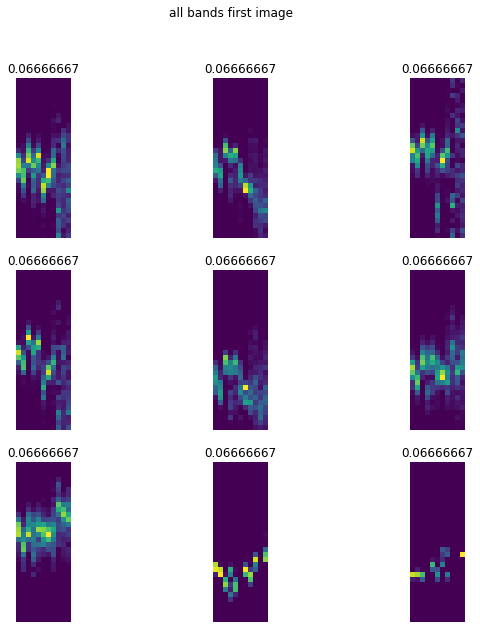

In [6]:
image_batch_train, label_batch_train = next(iter(train_ds))
image_batch_val, label_batch_val= next(iter(val_ds))
image_batch_test, label_batch_test= next(iter(test_ds))

# Check if images are correct
plt.figure(figsize=(10, 10))
plt.suptitle("all bands first image")
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  # print(image_batch_train[i].shape)
  plt.imshow(image_batch_train[0][:,:,i].numpy())
  label = label_batch_train[0]
  plt.title(label.numpy())
  plt.axis("off")

plt.show()

## Build Model: CNN

In [7]:
model = models.Sequential()

model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', input_shape=shape))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(2048))
model.add(layers.Dense(1))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 11, 128)       10496     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 11, 128)       512       
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 11, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 11, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 6, 128)        147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 6, 128)        512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 6, 128)        0

In [8]:
initial_learning_rate = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError(name='RMSE'), tf.keras.losses.MeanSquaredError(name='MSE')])

### Create Callbacks for model fit

In [9]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath= 'checkpoint_b{}_CNN-LSTM.h5'.format(batch_size),
    format='h5',
    verbose=1,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=50, verbose=1,
    mode='min', min_lr=0.0000000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=100, verbose=1)

## Training

In [10]:
print("Start training... ")
history = model.fit(train_ds,
                    epochs=1000,
                    validation_data=val_ds,
                    verbose=1,
                    callbacks=[model_checkpoint_callback, reducelronplateau, early_stop])


Start training... 
Epoch 1/1000
615/615 [==============================] - 15s 12ms/step - loss: 160.3513 - accuracy: 0.0594 - RMSE: 11.7354 - MSE: 160.3513 - val_loss: 0.2623 - val_accuracy: 0.0000e+00 - val_RMSE: 0.5122 - val_MSE: 0.2623

Epoch 00001: val_loss improved from inf to 0.26232, saving model to checkpoint_b1_CNN-LSTM.h5
Epoch 2/1000
615/615 [==============================] - 7s 11ms/step - loss: 0.8108 - accuracy: 0.0795 - RMSE: 0.8987 - MSE: 0.8108 - val_loss: 0.3693 - val_accuracy: 0.0000e+00 - val_RMSE: 0.6077 - val_MSE: 0.3693

Epoch 00002: val_loss did not improve from 0.26232
Epoch 3/1000
615/615 [==============================] - 7s 11ms/step - loss: 0.6652 - accuracy: 0.0635 - RMSE: 0.8111 - MSE: 0.6652 - val_loss: 0.2546 - val_accuracy: 0.0000e+00 - val_RMSE: 0.5045 - val_MSE: 0.2546

Epoch 00003: val_loss improved from 0.26232 to 0.25456, saving model to checkpoint_b1_CNN-LSTM.h5
Epoch 4/1000
615/615 [==============================] - 7s 11ms/step - loss: 0.5868 

### Plots 

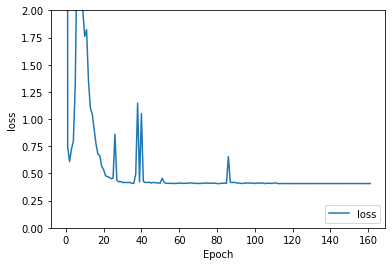

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 2.0])
plt.legend(loc='lower right')
plt.show()

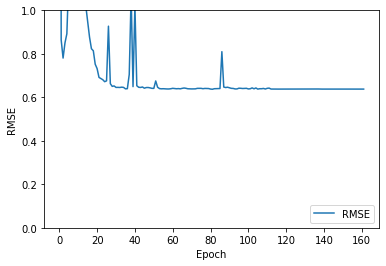

In [12]:
plt.plot(history.history['RMSE'], label='RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

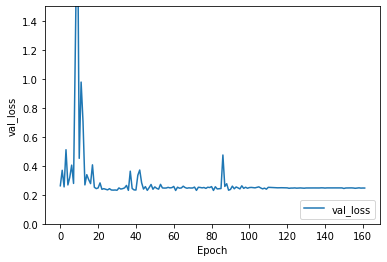

In [13]:
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('val_loss')
plt.ylim([0, 1.5])
plt.legend(loc='lower right')
plt.show()

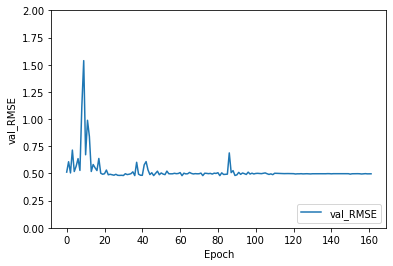

In [14]:
plt.plot(history.history['val_RMSE'], label = 'val_RMSE')
plt.xlabel('Epoch')
plt.ylabel('val_RMSE')
plt.ylim([0,2])
plt.legend(loc='lower right')
plt.show()

### Evaluation 

In [15]:
print("\nEvaluating val ds... ")
test_loss, test_acc, test_rmse, test_mse = model.evaluate(val_ds, verbose=1)


Evaluating val ds... 
76/76 [==============================] - 0s 4ms/step - loss: 0.2467 - accuracy: 0.0921 - RMSE: 0.4966 - MSE: 0.2467


In [16]:
print("\nEvaluating test ds... ")
test_loss, test_acc, test_rmse, test_mse = model.evaluate(test_ds, verbose=1)


Evaluating test ds... 
1/1 [==============================] - 0s 223ms/step - loss: 0.3383 - accuracy: 0.0395 - RMSE: 0.5817 - MSE: 0.3383


### Prediction

predictions shape: (1, 1)
prediction: [[0.7290736]]


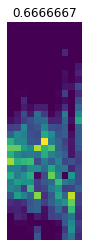

In [17]:
plt.imshow(image_batch_val[0][:,:,0])
label = label_batch_val[0].numpy()
plt.title(label)
plt.axis("off")
predictions = model.predict(image_batch_val)
print("predictions shape:", predictions.shape)
print("prediction:", predictions)

<BarContainer object of 76 artists>

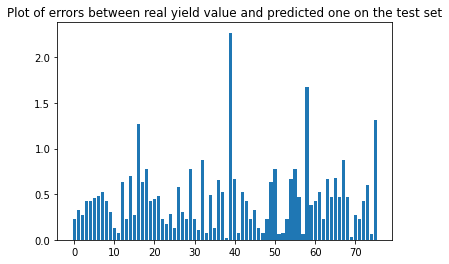

In [18]:
indexes_list = []
for i in range(len(image_batch_test)):
  indexes_list.append(i)

predictions = model.predict(test_ds)
error = abs(predictions[:][0] - label_batch_test.numpy())
plt.title("Plot of errors between real yield value and predicted one on the test set")
plt.bar(indexes_list,error)

<BarContainer object of 76 artists>

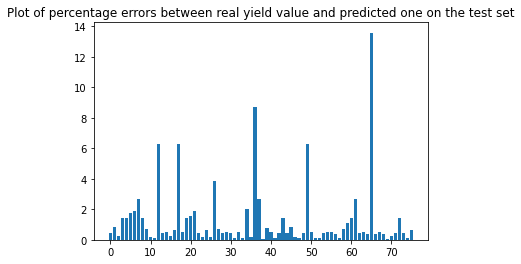

In [19]:
indexes_list = []
for i in range(len(image_batch_test)):
  indexes_list.append(i)

predictions = model.predict(test_ds)
error = abs(predictions[:][0] - label_batch_test.numpy())/label_batch_test.numpy()
# print(error[29])
# print(label_batch_test[29].numpy())
plt.title("Plot of percentage errors between real yield value and predicted one on the test set")
plt.bar(indexes_list,error)